In [662]:
import pandas as pd
import numpy as np
import scipy.optimize as optimize
import os
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics
import math
import datetime
import warnings
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import xgboost as xgb
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from ipywidgets import HBox, VBox
from tabulate import tabulate
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, plot_tree
#Matplotlib style
plt.style.use('fivethirtyeight')
#Ignoring some warnings
warnings.filterwarnings('ignore')

In [834]:
inputs = pd.read_csv(r'../Data/all_inputs_cleaned.csv')
outputs = pd.read_csv(r'../Data/all_outputs_cleaned.csv')

# Prediction for Construction

In [664]:
fig = px.line(outputs['Construction'], width=1000, height=500)
fig.update_layout(title_text='Monthly employment data of Construction from 2006-06-01 to 2023-09-01')
fig.show()

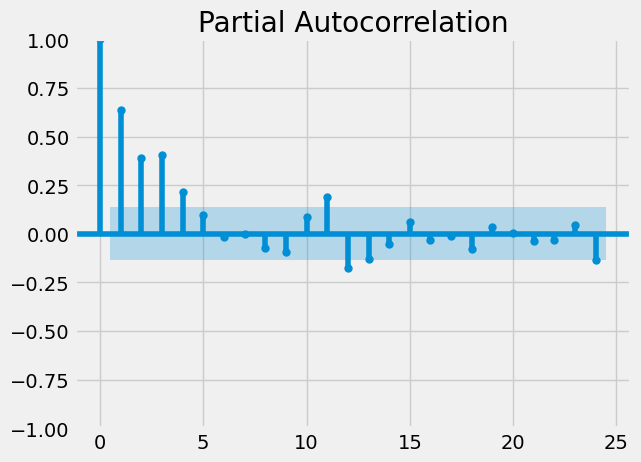

In [665]:
#This code uses the pacf() function from the tsa.stattools module of the statsmodels library (sm) to compute the autocorrelation function.
plot_pacf(outputs['Construction'],method="yw")
#Print the visualization
plt.show()

In [811]:
const_data = outputs[['Month','Construction']]
#Convert the date column to datetime format
const_data["Month"] = pd.to_datetime(const_data["Month"])
for i in range(1,5):
    const_data['prev'+str(i)]=const_data['Construction'].shift(i)
train_ml, test_ml, y_train, y_test = train_test_split(const_data, const_data['Construction'], test_size=0.2, random_state=0)

In [812]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['Month'].dt.quarter
    df['month'] = df['Month'].dt.month
    df['year'] = df['Month'].dt.year
    df['CPI'] = inputs.iloc[:,2]
    df['InterestRate'] = inputs.iloc[:,3]
    df['GDP'] = inputs.iloc[:,4]
    df['ValAddConst'] = inputs.iloc[:,5]
    df['ValAddInfo'] = inputs.iloc[:,6]
    df['Borrowing'] = inputs.iloc[:,7]
    df['CommercialLoan'] = inputs.iloc[:,8]
    df['ConsumerLoan'] = inputs.iloc[:,9]
    df['Deficit'] = inputs.iloc[:,10]
    df['ITBPrice'] = inputs.iloc[:,11]
    df['ITBVol'] = inputs.iloc[:,12]
    df['VGTPrice'] = inputs.iloc[:,13]
    df['VGTVol'] = inputs.iloc[:,14]
    df['S&P500Price'] = inputs.iloc[:,15]
    df['S&P500Vol'] = inputs.iloc[:,16]
    # X = df[['quarter','month','year']]
    features = ['quarter','month','year','CPI', 'InterestRate', 'GDP','Borrowing', 'ITBVol', 'VGTVol']
    for i in range(1,5):
        features.append('prev'+str(i))
    X = df[features]
#     X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP', 'ValAddConst', 'ValAddInfo','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'ITBVol','VGTPrice', 'VGTVol','S&P500Price','S&P500Vol']]
    # X = df[['month','year','CPI', 'GDP', 'ValAddConst','Borrowing','Deficit','ITBPrice','VGTPrice', 'VGTVol']]
    if label:
        y = df[label]
        return X, y
    return X

In [813]:
# X, y = create_features(const_data, label="Construction")
# X.head()
# kfold = KFold(n_splits=5, shuffle=True, random_state=0)
# # reg = xgb.XGBRegressor(
# #     n_estimators=200, 
# #     learning_rate=0.05, 
# #     max_depth=4, 
# #     min_child_weight=1,
# #     subsample=0.8,
# #     colsample_bytree=0.8,
# #     reg_lambda=1,
# #     alpha=0
# # )
# reg = xgb.XGBRegressor()
# results = cross_val_score(reg, X, y, cv=kfold, scoring='neg_mean_squared_error')

In [814]:
# Creating the features for the train and test sets
X_train, y_train = create_features(train_ml, label="Construction")
X_test, y_test = create_features(test_ml, label="Construction")
X_train.head()

,quarter,month,year,CPI,InterestRate,GDP,Borrowing,ITBVol,VGTVol,prev1,prev2,prev3,prev4
116,1,2,2016,-0.001076,0.416667,0.005668,-0.000176,-0.310354,-0.152303,0.000151,0.004850,0.007790,0.005993
55,1,1,2011,0.002534,-0.052632,0.010252,-0.022067,0.592563,0.500703,-0.007083,-0.000363,0.001272,-0.004164
26,3,8,2008,0.010478,0.005000,0.010267,-0.002030,-0.131256,0.202220,-0.007348,-0.008386,-0.007234,-0.010667
130,2,4,2017,0.001593,0.196970,0.010136,0.018368,0.095294,0.033099,0.003052,0.005994,0.003227,-0.000733
178,3,8,2021,0.007879,0.250000,0.012030,-0.027973,-0.246957,-0.360874,0.002027,0.000811,-0.001620,0.001487


In [815]:
#Defining and fitting the model
reg = xgb.XGBRegressor(n_estimators=300,early_stopping_rounds=60,)
# reg = xgb.XGBRegressor(
#     n_estimators=200, 
#     learning_rate=0.009, 
#     max_depth=5, 
#     min_child_weight=1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=1,  # Corrected parameter name
#     alpha=0,
# )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

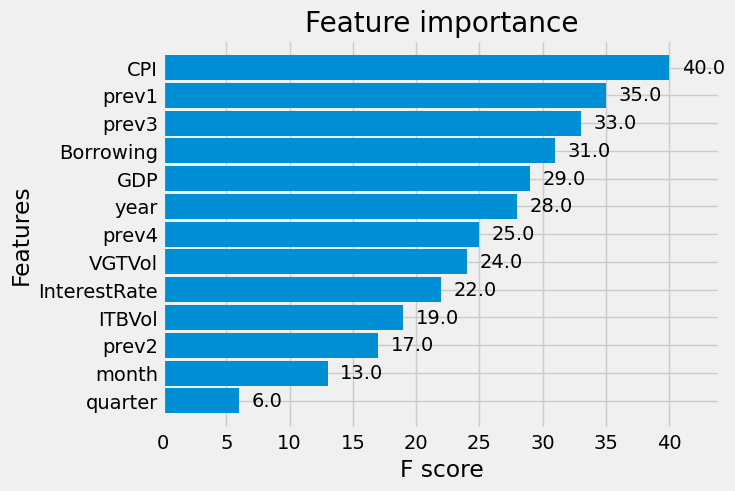

In [816]:
#Plot of feature importance
_ = plot_importance(reg, height=0.9)

In [817]:
#Predicting with our model for both the train and test data
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [818]:
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["Construction"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Construction",0:"Predicted Construction"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Construction TRAIN', width=1000, height=500)
XGBoost_and_rolling.show()

In [819]:
#Plotting the predictions of the testing data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(test_ml["Prediction"]),list(test_ml["Construction"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Construction",0:"Predicted Construction"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Construction TEST', width=1000, height=500)
XGBoost_and_rolling.show()

In [820]:
pred_sign = np.sign(train_ml['Predictions'])
y_test_sign = np.sign(train_ml['Construction'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9693251533742331

In [821]:
pred_sign = np.sign(test_ml['Prediction'])
y_test_sign = np.sign(test_ml['Construction'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.7804878048780488

Metrics:


Root Mean Square Error, RMSE: Square root of the mean of the difference between the actual data points and the squared prediction value. It penalizes greater or extreme differences more.

Mean Absolute Percentage Error, MAPE: It allows to measure errors relative to the magnitude of the real value.

In [822]:
RMSE_Serie_XG = mean_squared_error(train_ml["Construction"],train_ml["Predictions"],squared=False)
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["Construction"], train_ml["Predictions"])
print(f"The RMSE of our XGBOOST model in the full serie data is {round(RMSE_Serie_XG,4)}")
print(f"The MAPE of our XGBOOST model in the full serie data is {round(MAPE_Serie_XG*100,2)}%")

The RMSE of our XGBOOST model in the full serie data is 0.0008
The MAPE of our XGBOOST model in the full serie data is 29.79%


In [823]:
true_vol = test_ml['Prediction']
pred_vol = test_ml["Construction"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0038
The MAPE of our XGBOOST model in the predicted data is 133.95%


In [824]:
X, y = create_features(const_data, label="Construction")
const_data["Predictions"] = reg.predict(X)
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(const_data["Predictions"]),list(const_data["Construction"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Construction",0:"Predicted Construction"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Construction FULL', width=1000, height=500)
XGBoost_and_rolling.show()

In [825]:
pred_sign = np.sign(const_data['Predictions'])
y_test_sign = np.sign(const_data['Construction'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9313725490196079

In [826]:
true_vol = const_data['Predictions']
pred_vol = const_data["Construction"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")
r2_score = sklearn.metrics.r2_score(true_vol, pred_vol)
print(f"The R^2 score of our XGBOOST model in the predicted data is {round(r2_score,4)}")

The RMSE of our XGBOOST model in the predicted data is 0.0019
The MAPE of our XGBOOST model in the predicted data is 57.08%
The R^2 score of our XGBOOST model in the predicted data is 0.8898


# Prediction for Information

In [495]:
fig = px.line(outputs['Information'], width=1000, height=500)
fig.update_layout(title_text='Monthly employment data of Information from 2006-06-01 to 2023-09-01')
fig.show()

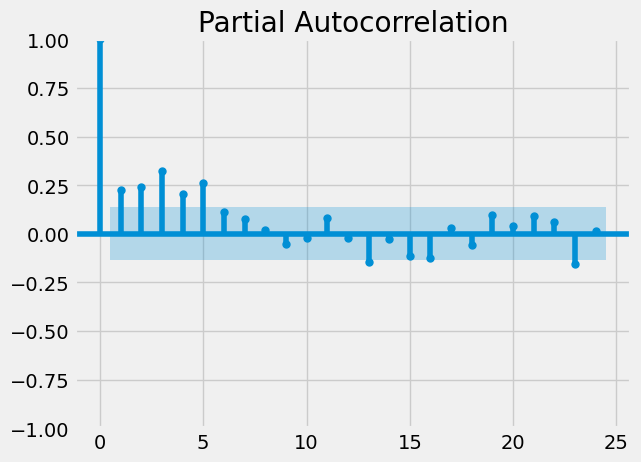

In [496]:
plot_pacf(outputs['Information'],method="yw")
#Print the visualization
plt.show()

In [497]:
info_data = outputs[['Month','Information']]
#Convert the date column to datetime format
info_data["Month"] = pd.to_datetime(info_data["Month"])
for i in range(1,6):
    info_data['prev'+str(i)]=info_data['Information'].shift(i)
train_ml, test_ml, y_train, y_test = train_test_split(info_data, info_data['Information'], test_size=0.1, random_state=0)

In [498]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['Month'].dt.quarter
    df['month'] = df['Month'].dt.month
    df['year'] = df['Month'].dt.year
    df['CPI'] = inputs.iloc[:,2]
    df['InterestRate'] = inputs.iloc[:,3]
    df['GDP'] = inputs.iloc[:,4]
    df['ValAddConst'] = inputs.iloc[:,5]
    df['ValAddInfo'] = inputs.iloc[:,6]
    df['Borrowing'] = inputs.iloc[:,7]
    df['CommercialLoan'] = inputs.iloc[:,8]
    df['ConsumerLoan'] = inputs.iloc[:,9]
    df['Deficit'] = inputs.iloc[:,10]
    df['ITBPrice'] = inputs.iloc[:,11]
    df['ITBVol'] = inputs.iloc[:,12]
    df['VGTPrice'] = inputs.iloc[:,13]
    df['VGTVol'] = inputs.iloc[:,14]
    df['S&P500Price'] = inputs.iloc[:,15]
    df['S&P500Vol'] = inputs.iloc[:,16]
    # X = df[['quarter','month','year']]
    # X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP', 'ValAddConst', 'ValAddInfo','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'ITBVol','VGTPrice', 'VGTVol','S&P500Price','S&P500Vol']]
    # X = df[['quarter','CPI', 'InterestRate','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'VGTVol','S&P500Price','S&P500Vol']]
#     X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice','VGTPrice','S&P500Price']]
    features = ['quarter','year','CPI', 'InterestRate', 'GDP','CommercialLoan', 'ConsumerLoan','ITBPrice', 'ITBVol', 'VGTVol']
    for i in range(1,6):
        features.append('prev'+str(i))
    X = df[features]
    if label:
        y = df[label]
        return X, y
    return X

In [499]:
#Creating the features for the train and test sets
X_train, y_train = create_features(train_ml, label="Information")
X_test, y_test = create_features(test_ml, label="Information")
X_train.head()

,quarter,year,CPI,InterestRate,GDP,CommercialLoan,ConsumerLoan,ITBPrice,ITBVol,VGTVol,prev1,prev2,prev3,prev4,prev5
146,3,2018,0.000901,0.049451,0.010747,0.099,0.046,-0.022609,-0.349344,0.275980,0.001057,-0.001056,0.001057,0.004246,0.002483
63,3,2011,0.002620,0.428571,0.011032,0.101,-0.013,-0.041697,-0.494434,-0.320822,-0.016075,-0.003724,0.002240,0.001870,0.000749
135,3,2017,0.000328,0.008696,0.009369,0.020,0.059,0.025896,0.767551,0.118864,0.001424,-0.000711,0.003570,-0.001070,-0.003199
86,3,2013,0.002380,0.000000,0.007849,0.091,0.048,-0.053228,0.082071,-0.172333,0.005545,-0.001845,0.005193,-0.001481,0.000741
141,1,2018,0.004253,0.007092,0.012049,0.024,0.052,-0.024094,-0.389617,0.024057,0.000710,-0.000355,0.001066,0.001423,-0.001776


In [500]:
#Defining and fitting the model
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=60,)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

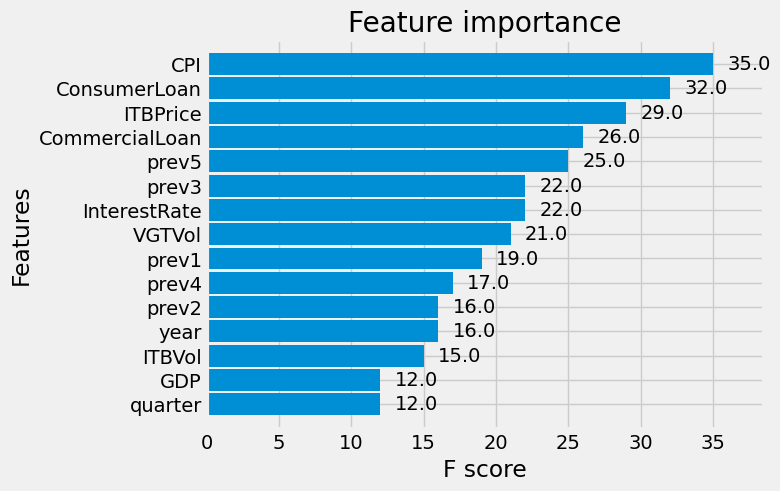

In [501]:
#Plot of feature importance
_ = plot_importance(reg, height=0.9)

In [502]:
#Predicting with our model for both the train and test data
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [503]:
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["Information"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Information",0:"Predicted Information"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Information TRAIN', width=1000, height=500)
XGBoost_and_rolling.show()

In [504]:
#Plotting the predictions of the testing data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(test_ml["Prediction"]),list(test_ml["Information"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Information",0:"Predicted Information"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Information TEST', width=1000, height=500)
XGBoost_and_rolling.show()

In [505]:
pred_sign = np.sign(train_ml['Predictions'])
y_test_sign = np.sign(train_ml['Information'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.953551912568306

In [506]:
pred_sign = np.sign(test_ml['Prediction'])
y_test_sign = np.sign(test_ml['Information'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.7857142857142857

In [507]:
RMSE_Serie_XG = mean_squared_error(train_ml["Information"],train_ml["Predictions"],squared=False)
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["Information"], train_ml["Predictions"])
print(f"The RMSE of our XGBOOST model in the full serie data is {round(RMSE_Serie_XG,4)}")
print(f"The MAPE of our XGBOOST model in the full serie data is {round(MAPE_Serie_XG*100,2)}%")

The RMSE of our XGBOOST model in the full serie data is 0.0011
The MAPE of our XGBOOST model in the full serie data is 3338878707443.43%


In [508]:
true_vol = test_ml['Prediction']
pred_vol = test_ml["Information"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0033
The MAPE of our XGBOOST model in the predicted data is 1319.57%


In [509]:
X, y = create_features(info_data, label="Information")
info_data["Predictions"] = reg.predict(X)
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(info_data["Predictions"]),list(info_data["Information"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Information",0:"Predicted Information"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Information FULL', width=1000, height=500)
XGBoost_and_rolling.show()

In [510]:
pred_sign = np.sign(info_data['Predictions'])
y_test_sign = np.sign(info_data['Information'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9362745098039216

In [511]:
true_vol = info_data['Predictions']
pred_vol = info_data["Information"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0015
The MAPE of our XGBOOST model in the predicted data is 218.55%


# Prediction for Total Private

In [512]:
fig = px.line(outputs['Total_Private'], width=1000, height=500)
fig.update_layout(title_text='Monthly employment data of Total_Private from 2006-06-01 to 2023-09-01')
fig.show()

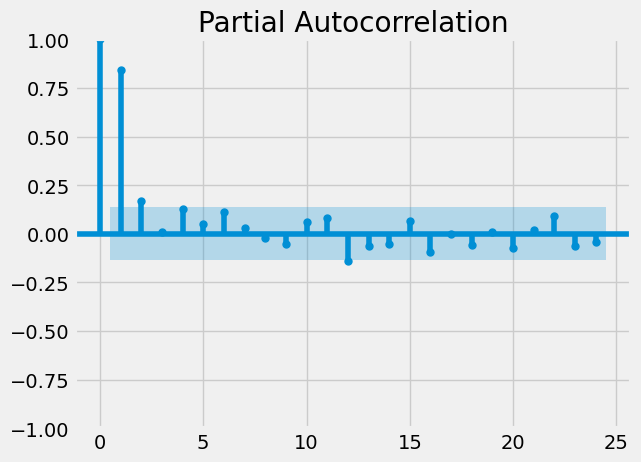

In [513]:
plot_pacf(outputs['Total_Private'],method="yw")
#Print the visualization
plt.show()

In [514]:
totpriv_data = outputs[['Month','Total_Private']]
#Convert the date column to datetime format
totpriv_data["Month"] = pd.to_datetime(totpriv_data["Month"])
for i in range(1,6):
    totpriv_data['prev'+str(i)]=totpriv_data['Total_Private'].shift(i)
train_ml, test_ml, y_train, y_test = train_test_split(totpriv_data, totpriv_data['Total_Private'], test_size=0.2, random_state=0)

In [515]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['Month'].dt.quarter
    df['month'] = df['Month'].dt.month
    df['year'] = df['Month'].dt.year
    df['CPI'] = inputs.iloc[:,2]
    df['InterestRate'] = inputs.iloc[:,3]
    df['GDP'] = inputs.iloc[:,4]
    df['ValAddConst'] = inputs.iloc[:,5]
    df['ValAddInfo'] = inputs.iloc[:,6]
    df['Borrowing'] = inputs.iloc[:,7]
    df['CommercialLoan'] = inputs.iloc[:,8]
    df['ConsumerLoan'] = inputs.iloc[:,9]
    df['Deficit'] = inputs.iloc[:,10]
    df['ITBPrice'] = inputs.iloc[:,11]
    df['ITBVol'] = inputs.iloc[:,12]
    df['VGTPrice'] = inputs.iloc[:,13]
    df['VGTVol'] = inputs.iloc[:,14]
    df['S&P500Price'] = inputs.iloc[:,15]
    df['S&P500Vol'] = inputs.iloc[:,16]
    # X = df[['quarter','month','year']]
#     X = df[['year','CommercialLoan','VGTPrice', 'CPI']]
    features = ['year','CommercialLoan','VGTPrice','CPI']
    for i in range(1,3):
        features.append('prev'+str(i))
    X = df[features]
    # X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP', 'ValAddConst', 'ValAddInfo','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'ITBVol','VGTPrice', 'VGTVol','S&P500Price','S&P500Vol']]
    if label:
        y = df[label]
        return X, y
    return X

In [516]:
#Creating the features for the train and test sets
X_train, y_train = create_features(train_ml, label="Total_Private")
X_test, y_test = create_features(test_ml, label="Total_Private")
X_train.head()

,year,CommercialLoan,VGTPrice,CPI,prev1,prev2
116,2016,0.041,-0.019105,-0.001076,0.000810,0.002129
55,2011,0.020,0.036492,0.002534,0.000940,0.001329
26,2008,0.057,0.042413,0.010478,-0.002153,-0.001664
130,2017,0.000,0.005260,0.001593,0.001028,0.001589
178,2021,-0.298,0.024310,0.007879,0.005905,0.005066


In [517]:
#Defining and fitting the model
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=60,)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

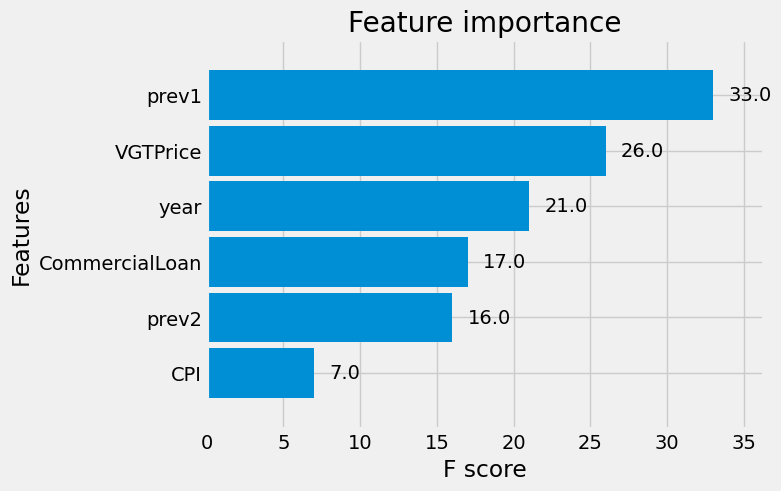

In [518]:
#Plot of feature importance
_ = plot_importance(reg, height=0.9)

In [519]:
#Predicting with our model for both the train and test data
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [520]:
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["Total_Private"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Total_Private",0:"Predicted Total_Private"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Total_Private TRAIN', width=1000, height=500)
XGBoost_and_rolling.show()

In [521]:
#Plotting the predictions of the testing data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(test_ml["Prediction"]),list(test_ml["Total_Private"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Total_Private",0:"Predicted Total_Private"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Total_Private TEST', width=1000, height=500)
XGBoost_and_rolling.show()

In [522]:
pred_sign = np.sign(train_ml['Predictions'])
y_test_sign = np.sign(train_ml['Total_Private'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9877300613496932

In [523]:
pred_sign = np.sign(test_ml['Prediction'])
y_test_sign = np.sign(test_ml['Total_Private'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

1.0

In [524]:
RMSE_Serie_XG = mean_squared_error(train_ml["Total_Private"],train_ml["Predictions"],squared=False)
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["Total_Private"], train_ml["Predictions"])
print(f"The RMSE of our XGBOOST model in the full serie data is {round(RMSE_Serie_XG,4)}")
print(f"The MAPE of our XGBOOST model in the full serie data is {round(MAPE_Serie_XG*100,2)}%")

The RMSE of our XGBOOST model in the full serie data is 0.0005
The MAPE of our XGBOOST model in the full serie data is 44.05%


In [525]:
true_vol = test_ml['Prediction']
pred_vol = test_ml["Total_Private"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0014
The MAPE of our XGBOOST model in the predicted data is 43.04%


In [526]:
X, y = create_features(totpriv_data, label="Total_Private")
totpriv_data["Predictions"] = reg.predict(X)
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(totpriv_data["Predictions"]),list(totpriv_data["Total_Private"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Total_Private",0:"Predicted Total_Private"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Total_Private FULL', width=1000, height=500)
XGBoost_and_rolling.show()

In [527]:
pred_sign = np.sign(totpriv_data['Predictions'])
y_test_sign = np.sign(totpriv_data['Total_Private'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9901960784313726

In [528]:
true_vol = totpriv_data['Predictions']
pred_vol = totpriv_data["Total_Private"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0008
The MAPE of our XGBOOST model in the predicted data is 26.89%
